# Pytorch Fashion MNIST

<img src="https://drive.google.com/uc?id=1s6I1DGhf5FOh1lNszHj-Bl0puaxL8QkE" width="800"> 

* In this notebook we illustrate how to classify images of fashion items from the Fashin MNIST dataset
* This is a multi-class classification problem, with 10 output classes, corresponding to 10 items
<p/>
<img width="700" src="https://drive.google.com/uc?id=1zWS559utl0snWVyZ4wBHjSU6_cLUrkl2"/>


In [1]:
# Connect to Google drive, so I can import modules from it into my workspace
# set this flag to True when you run this Notebook on Google Collaboratory
USE_COLAB = False

import os

#@see: https://colab.research.google.com/drive/1srw_HFWQ2SMgmWIawucXfusGzrj1_U0q
if USE_COLAB:
    # Load the Drive helper and mount
    from google.colab import drive

    # This will prompt for authorization.
    gdrive_mount_point = '/content/drive/'
    drive.mount(gdrive_mount_point)
    grive_path = os.path.join(gdrive_mount_point, "My Drive/")
    print('Your Google Drive is mounted at ', grive_path)
    COLAB_NOTEBOOKS_PATH = os.path.join(grive_path, "Colab Notebooks/")
    
    if os.path.exists(COLAB_NOTEBOOKS_PATH):    
        # display list of files
        #!ls '/content/drive/My Drive/Colab Notebooks/'

        # append our Google Drive folder to module search 
        # **NOTE:** comment this line out if you are NOT running this notebook on Google Colab
        import sys
        #sys.path.append("/content/drive/My Drive/Colab Notebooks/")
        pyt_path = os.path.join(COLAB_NOTEBOOKS_PATH, 'pytorch')
        sys.path.append(pyt_path)
        print('You Pytorch Colab notebooks are available at ', pyt_path)
        print('NOTE: {} is appended to sys.path!'.format(pyt_path))
        # and test it
        import pytorch_toolkit as pytk
        MODEL_SAVE_DIR = os.path.join(pyt_path, 'model_states')
    else:
        raise IOError("Unable to mount Google Drive!")
else:
    MODEL_SAVE_DIR = os.path.join('.','model_states')
    
if not os.path.exists(MODEL_SAVE_DIR):
    os.mkdir(MODEL_SAVE_DIR)

assert os.path.exists(MODEL_SAVE_DIR)
print('MODEL_SAVE_DIR = %s' % MODEL_SAVE_DIR)

MODEL_SAVE_DIR = .\model_states


## About the Dataset

* The **MNIST digits dataset** is a database of handwritten digits. The latest & greatest version is [available from this page](http://yann.lecun.com/exdb/mnist/). 
* Pytorch ships with the MNIST dataset in `torchvision.datasets` package. We will be downloading from there.

In [2]:
import warnings
warnings.filterwarnings('ignore')

import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from PIL import Image
%matplotlib inline

# tweaks for libraries
np.set_printoptions(precision=6, linewidth=1024, suppress=True)
plt.style.use('seaborn')
sns.set_style('darkgrid')
sns.set_context('notebook',font_scale=1.10)

# Pytorch imports
import torch
gpu_available = torch.cuda.is_available()
print('Using Pytorch version %s. GPU %s available' % (torch.__version__, "IS" if gpu_available else "IS **NOT**"))
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch import optim
from torchsummary import summary

# import the Pytorch Toolkit here....
import pytorch_toolkit as pytk

# to ensure that you get consistent results across various machines
# @see: https://discuss.pytorch.org/t/reproducibility-over-different-machines/63047
seed = 123
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = True

Using Pytorch version 1.8.1+cpu. GPU IS **NOT** available


### Loading and Pre-processing data

* **Loading**: We load the dataset from the `keras.datasets.mnist` package using the `load_data()` call. 
    * This call returns 2 sets of data - the `train` set `(X_train/y_train)` comprising 60,000 samples and the `test` set `(X_test/y_test)` comprising 10,000 samples.
* **Pre-processing**: Following pre-processing steps are applied
* Split the _test set_ into a _cross-validation_ set `(X_val/y_val)` and _test_ set, with 8,000 samples in the _cross-validation_ set and 2,000 in the test set
* Normalize the images (Xs) to values between 0-1 and one-hot-encode each label (y's) to 10 classes width
* Reshape each image file (i.e. X's) into 2D array of shape `(?, 28*28*1)` 
* _NOTE:_ a non-pre-processed copy of `X_test/y_test` is also returned, used for visualization purposes only!


In [3]:
def load_data():
    """
    load the data using datasets API. We also split the test_dataset into 
    cross-val/test datasets using 80:20 ration
    """
    transformations = transforms.Compose([transforms.ToTensor(),])

    train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transformations)

    print("No of training records: %d" % len(train_dataset))

    test_dataset = datasets.FashionMNIST('./data', download=True, train=False, transform=transformations)
    print("No of test records: %d" % len(test_dataset))

    # lets split the test dataset into val_dataset & test_dataset -> 8000:2000 records
    val_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [8000, 2000])
    print("No of cross-val records: %d" % len(val_dataset))
    print("No of test records: %d" % len(test_dataset))

    return train_dataset, val_dataset, test_dataset

In [4]:
def display_sample(sample_images, sample_labels, grid_shape=(10, 10), plot_title=None,
                   sample_predictions=None):
    # just in case these are not imported!
    import matplotlib.pyplot as plt
    import seaborn as sns
    plt.style.use('seaborn')

    num_rows, num_cols = grid_shape
    assert sample_images.shape[0] == num_rows * num_cols

    # a dict to help encode/decode the labels
    FASHION_LABELS = {
        0: 'T-shirt/top',
        1: 'Trouser',
        2: 'Pullover',
        3: 'Dress',
        4: 'Coat',
        5: 'Sandal',
        6: 'Shirt',
        7: 'Sneaker',
        8: 'Bag',
        9: 'Ankle boot',
    }

    with sns.axes_style("whitegrid"):
        sns.set_context("notebook", font_scale=1.10)
        sns.set_style({"font.sans-serif": ["Verdana", "Arial", "Calibri", "DejaVu Sans"]})

        f, ax = plt.subplots(num_rows, num_cols, figsize=(14, 10),
            gridspec_kw={"wspace": 0.05, "hspace": 0.35}, squeeze=True)  # 0.03, 0.25
        #fig = ax[0].get_figure()
        f.tight_layout()
        f.subplots_adjust(top=0.90) # 0.93

        for r in range(num_rows):
            for c in range(num_cols):
                image_index = r * num_cols + c
                ax[r, c].axis("off")
                # show selected image
                ax[r, c].imshow(sample_images[image_index].squeeze(), cmap="Greys", interpolation='nearest')

                if sample_predictions is None:
                    # but show the prediction in the title
                    title = ax[r, c].set_title(f"{FASHION_LABELS[sample_labels[image_index]]}")
                else:
                    pred_matches_actual = (
                                sample_labels[image_index] == sample_predictions[image_index])
                    if pred_matches_actual:
                        # show title from prediction or actual in green font
                        title = '%s' % FASHION_LABELS[sample_predictions[image_index]]
                        title_color = 'g'
                    else:
                        # show title as actual/prediction in red font
                        title = '%s/%s' % (FASHION_LABELS[sample_labels[image_index]],
                                           FASHION_LABELS[sample_predictions[image_index]])
                        title_color = 'r'

                    # but show the prediction in the title
                    title = ax[r, c].set_title(title)
                    # if prediction is incorrect title color is red, else green
                    plt.setp(title, color=title_color)

        if plot_title is not None:
            plt.suptitle(plot_title)
        plt.show()
        plt.close()

In [5]:
# (down)load
train_dataset, val_dataset, test_dataset = load_data()

No of training records: 60000
No of test records: 10000
No of cross-val records: 8000
No of test records: 2000


images.shape = torch.Size([64, 1, 28, 28]), labels.shape=torch.Size([64])


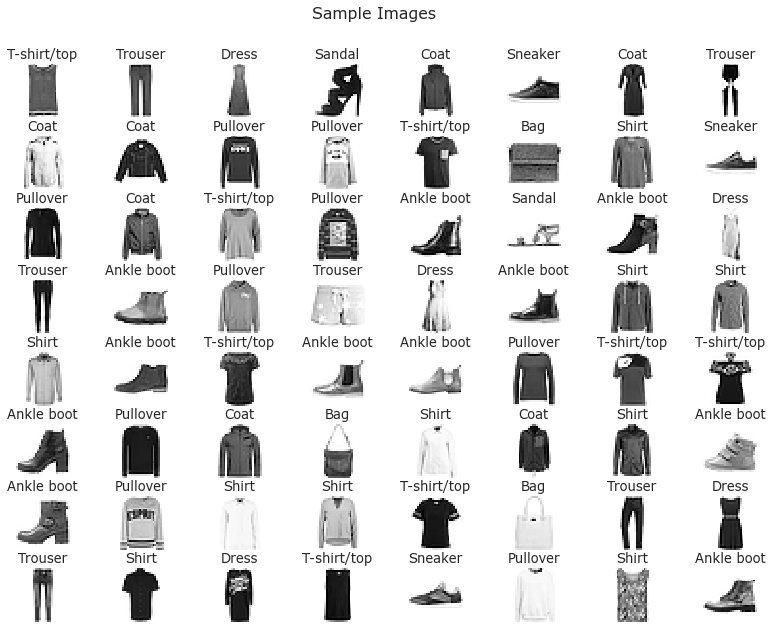

In [6]:
# display a sample
trainloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)
data_iter = iter(trainloader)
images, labels = data_iter.next()  # fetch first batch of 64 images & labels
print(f'images.shape = {images.shape}, labels.shape={labels.shape}')
#print(f'labels = {labels[:10]}')
display_sample(images.cpu().numpy(), labels.cpu().numpy(), grid_shape=(8, 8), plot_title='Sample Images')

## Pytorch Model Development

In [7]:
# some hyper-parameters
IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, NUM_CLASSES = 28, 28, 1, 10
NUM_EPOCHS, BATCH_SIZE, LEARNING_RATE, L2_REG = 50, 128, 0.001, 0.04
PY_MODEL_SAVE_PATH = os.path.join(MODEL_SAVE_DIR, 'pyt_fashion_mnist_dnn.pyt')

In [8]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

def build_model():
    net = nn.Sequential(
        pytk.Conv2d(1, 64, kernel_size=5, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        # pytk.Conv2d(64, 64, kernel_size=5, padding=1),
        # nn.ReLU(),
        # nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.20),

        pytk.Conv2d(64, 128, kernel_size=5, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        # pytk.Conv2d(128, 128, kernel_size=5, padding=1),
        # nn.ReLU(),
        # nn.BatchNorm2d(128),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.25),

        pytk.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(256),
        # pytk.Conv2d(256, 256, kernel_size=3, padding=1),
        # nn.ReLU(),
        # nn.BatchNorm2d(256),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.30),

        pytk.Conv2d(256, 512, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(512),
        # pytk.Conv2d(512, 512, kernel_size=3, padding=1),
        # nn.ReLU(),
        # nn.BatchNorm2d(512),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.35),

        Flatten(),

        nn.Linear(512*1*1, 512),
        nn.ReLU(),
        nn.Dropout(0.20),

        # nn.Linear(1024, 512),
        # nn.ReLU(),
        # nn.Dropout(0.15),

        # # nn.Linear(512, 128),
        # # nn.ReLU(),
        # #nn.Dropout(0.10),

        nn.Linear(512, NUM_CLASSES)     
    )

    model = pytk.PytkModuleWrapper(net)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(params=model.parameters(), lr=LEARNING_RATE, weight_decay=L2_REG)
    #optimizer = optim.SGD(params=model.parameters(), lr=LEARNING_RATE, momentum=0.0, nesterov=False, weight_decay=L2_REG)
    model.compile(loss=loss_fn, optimizer=optimizer, metrics=['acc'])
    return model, optimizer

In [9]:
# build model
model, optimizer = build_model()
print(model.summary((NUM_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 26, 26]           1,664
              ReLU-2           [-1, 64, 26, 26]               0
       BatchNorm2d-3           [-1, 64, 26, 26]             128
         MaxPool2d-4           [-1, 64, 13, 13]               0
           Dropout-5           [-1, 64, 13, 13]               0
            Conv2d-6          [-1, 128, 11, 11]         204,928
              ReLU-7          [-1, 128, 11, 11]               0
       BatchNorm2d-8          [-1, 128, 11, 11]             256
         MaxPool2d-9            [-1, 128, 5, 5]               0
          Dropout-10            [-1, 128, 5, 5]               0
           Conv2d-11            [-1, 256, 5, 5]         295,168
             ReLU-12            [-1, 256, 5, 5]               0
      BatchNorm2d-13            [-1, 256, 5, 5]             512
        MaxPool2d-14            [-1, 25

## Training Model
In this section, we will build & train several configurations of the model and evaluate performance

In [10]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)
hist = model.fit_dataset(train_dataset, validation_dataset=val_dataset, lr_scheduler=scheduler, 
                         epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)

Training on CPU...
Training on 60000 samples, cross-validating on 8000 samples
Epoch ( 1/50): (60000/60000) -> loss: 0.5063 - acc: 0.8202 - val_loss: 0.4875 - val_acc: 0.8379 - lr: ['0.00100000']
Epoch ( 2/50): (60000/60000) -> loss: 0.4490 - acc: 0.8485 - val_loss: 0.4506 - val_acc: 0.8550 - lr: ['0.00100000']
Epoch ( 3/50): (60000/60000) -> loss: 0.4620 - acc: 0.8531 - val_loss: 0.5632 - val_acc: 0.8354 - lr: ['0.00100000']
Epoch ( 4/50): (60000/60000) -> loss: 0.4785 - acc: 0.8568 - val_loss: 0.5443 - val_acc: 0.8353 - lr: ['0.00100000']
Epoch ( 5/50): (60000/60000) -> loss: 0.4779 - acc: 0.8591 - val_loss: 0.5609 - val_acc: 0.8212 - lr: ['0.00100000']
Epoch ( 6/50): (60000/60000) -> loss: 0.4766 - acc: 0.8576 - val_loss: 0.4635 - val_acc: 0.8548 - lr: ['0.00100000']
Epoch ( 7/50): (60000/60000) -> loss: 0.4829 - acc: 0.8568 - val_loss: 0.5516 - val_acc: 0.8237 - lr: ['0.00100000']
Epoch ( 8/50): (60000/60000) -> loss: 0.4819 - acc: 0.8571 - val_loss: 0.4440 - val_acc: 0.8565 - lr: 

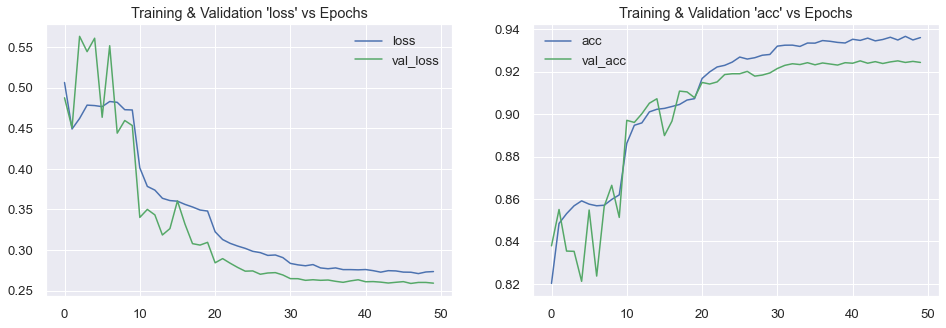

In [11]:
pytk.show_plots(hist, metric='acc')

In [12]:
# evaluate performance
print('Evaluating model performance...')
loss, acc = model.evaluate_dataset(train_dataset)
print6(f'  Training dataset -> loss: {loss:.4f} - acc: {acc:.4f}')
loss, acc = model.evaluate_dataset(val_dataset)
print(f'  Cross-val dataset -> loss: {loss:.4f} - acc: {acc:.4f}')
oss, acc = model.evaluate_dataset(test_dataset)
print(f'  Test dataset      -> loss: {loss:.4f} - acc: {acc:.4f}')

Evaluating model performance...
Evaluating (60000/60000) -> loss: 0.1984 - acc: 0.9548
  Training dataset  -> loss: 0.1984 - acc: 0.9548
Evaluating (8000/8000) -> loss: 0.2588 - acc: 0.9247
  Cross-val dataset -> loss: 0.2588 - acc: 0.9247
Evaluating (2000/2000) -> loss: 0.2618 - acc: 0.9253
  Test dataset      -> loss: 0.2588 - acc: 0.9253


#### Observation:
See [this Colab Notebook](https://colab.research.google.com/drive/1brSHFOnPQTo0-9vQRC6oslZjAGRbzWuY) for _examples on inserting tables inside markdown cells_
>Configuration | Training Acc | Cross-val Acc | Test Acc | Observation
>:---|:---:|:---:|:---:|:---:|
>**Model**|95.64%|92.80%|92.43%|Some Overfitting


In [13]:
model.save(PY_MODEL_SAVE_PATH)
del model

Pytorch model saved to c:\Dev\Code\Python\git-projects\dl-pytorch\model_states\pyt_fashion_mnist_dnn.pyt


## Making Predictions

In [14]:
model, optimizer = build_model()
model.load(PY_MODEL_SAVE_PATH)
print(model.summary((NUM_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH)))

Pytorch model loaded from c:\Dev\Code\Python\git-projects\dl-pytorch\model_states\pyt_fashion_mnist_dnn.pyt
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 26, 26]           1,664
              ReLU-2           [-1, 64, 26, 26]               0
       BatchNorm2d-3           [-1, 64, 26, 26]             128
         MaxPool2d-4           [-1, 64, 13, 13]               0
           Dropout-5           [-1, 64, 13, 13]               0
            Conv2d-6          [-1, 128, 11, 11]         204,928
              ReLU-7          [-1, 128, 11, 11]               0
       BatchNorm2d-8          [-1, 128, 11, 11]             256
         MaxPool2d-9            [-1, 128, 5, 5]               0
          Dropout-10            [-1, 128, 5, 5]               0
           Conv2d-11            [-1, 256, 5, 5]         295,168
             ReLU-12            [-1, 256, 5, 5]            

In [15]:
# run predictions
y_pred, y_true = model.predict_dataset(test_dataset)
y_pred = np.argmax(y_pred, axis=1)
print('Sample labels (50): ', y_true[:50])
print('Sample predictions (50): ', y_true[:50])
print('We got %d/%d incorrect!' % ((y_pred != y_true).sum(), len(y_true)))

Sample labels (50):  [8 0 3 0 2 4 3 5 7 2 4 0 3 7 4 5 3 2 2 2 7 2 1 5 1 1 7 4 6 6 4 1 3 8 7 3 9 5 8 3 8 3 4 1 9 2 9 2 0 2]
Sample predictions (50):  [8 0 3 0 2 4 3 5 7 2 4 0 3 7 4 5 3 2 2 2 7 2 1 5 1 1 7 4 6 6 4 1 3 8 7 3 9 5 8 3 8 3 4 1 9 2 9 2 0 2]
We got 145/2000 incorrect!


Displaying sample predictions...


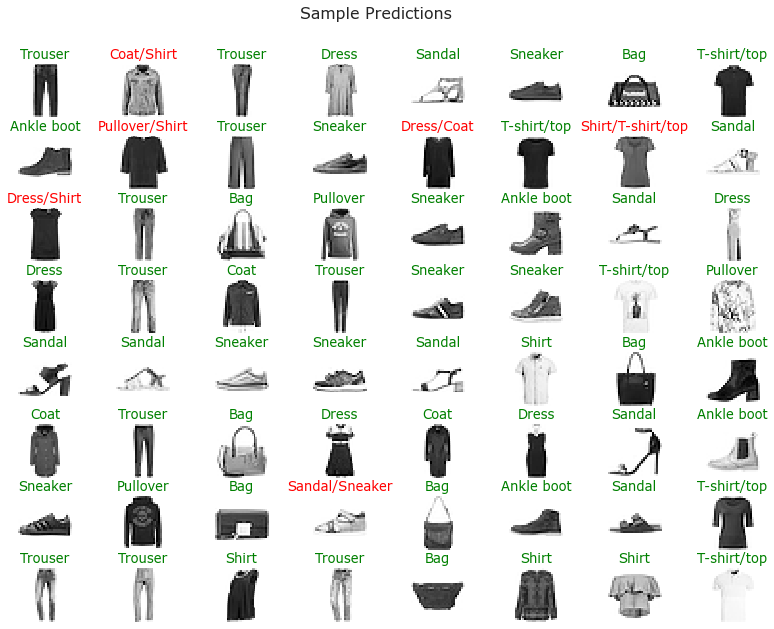

In [16]:
# display sample
print('Displaying sample predictions...')
trainloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)
data_iter = iter(trainloader)
images, labels = data_iter.next()  # fetch a batch of 64 random images
preds = model.predict(images)
preds = np.argmax(preds, axis=1)
#type(images), type(labels), type(preds)
display_sample(images, labels.cpu().numpy(), sample_predictions=preds,
                grid_shape=(8, 8), plot_title='Sample Predictions')

# <center> - - END - - </center>